In [1]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [2]:
import os
from math import floor

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

N = 100
X = torch.linspace(-1., 1., N)
probs = (torch.sin(X * math.pi).add(1.).div(2.))
y = torch.distributions.Bernoulli(probs=probs).sample()
X = X.unsqueeze(-1)

train_n = int(floor(0.8 * N))
indices = torch.randperm(N)
train_x = X[indices[:train_n]].contiguous()
train_y = y[indices[:train_n]].contiguous()

test_x = X[indices[train_n:]].contiguous()
test_y = y[indices[train_n:]].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

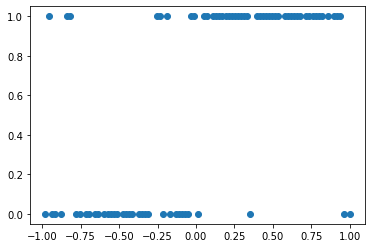

In [3]:
plt.plot(train_x.squeeze(-1), train_y, 'o')


In [4]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=100000, shuffle=False)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [5]:
class PGLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    # this method effectively computes the expected log likelihood
    # contribution to Eqn (10) in Reference [1].
    def expected_log_prob(self, target, input, *args, **kwargs):
        mean, variance = input.mean, input.variance
        # Compute the expectation E[f_i^2]
        raw_second_moment = variance + mean.pow(2)

        # Translate targets to be -1, 1
        target = target.to(mean.dtype).mul(2.).sub(1.)

        # We detach the following variable since we do not want
        # to differentiate through the closed-form PG update.
        c = raw_second_moment.detach().sqrt()
        # Compute mean of PG auxiliary variable omega: 0.5 * Expectation[omega]
        # See Eqn (11) and Appendix A2 and A3 in Reference [1] for details.
        half_omega = 0.25 * torch.tanh(0.5 * c) / c

        # Expected log likelihood
        res = 0.5 * target * mean - half_omega * raw_second_moment
        # Sum over data points in mini-batch
        res = res.sum(dim=-1)

        return res

    # define the likelihood
    def forward(self, function_samples):
        return torch.distributions.Bernoulli(logits=function_samples)

    # define the marginal likelihood using Gauss Hermite quadrature
    def marginal(self, function_dist):
        prob_lambda = lambda function_samples: self.forward(function_samples).probs
        probs = self.quadrature(prob_lambda, function_dist)
        return torch.distributions.Bernoulli(probs=probs)


# define the actual GP model (kernels, inducing points, etc.)
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# we initialize our model with M = 30 inducing points
M = 30
inducing_points = torch.linspace(-2., 2., M, dtype=train_x.dtype, device=train_x.device).unsqueeze(-1)
model = GPModel(inducing_points=inducing_points)
model.covar_module.base_kernel.initialize(lengthscale=0.2)
likelihood = PGLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [6]:
variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=train_y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

In [11]:
model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

num_epochs = 1 if smoke_test else 100
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)

    for x_batch, y_batch in minibatch_iter:
        ### Perform NGD step to optimize variational parameters
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()

        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

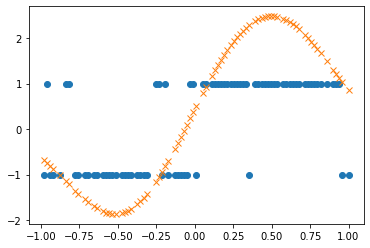

In [8]:
# push training data points through model
train_mean_f = model(train_x).loc.data.cpu()
# plot training data with y being -1/1 valued
plt.plot(train_x.squeeze(-1), train_y.mul(2.).sub(1.), 'o')
# plot mean gaussian process posterior mean evaluated at training data
plt.plot(train_x.squeeze(-1).cpu(), train_mean_f.cpu(), 'x')

In [9]:
model.eval()
likelihood.eval()
with torch.no_grad():
    nlls = -likelihood.log_marginal(test_y, model(test_x))
    acc = (likelihood(model(test_x)).probs.gt(0.5) == test_y.bool()).float().mean()
print('Test NLL: {:.4f}'.format(nlls.mean()))
print('Test Acc: {:.4f}'.format(acc.mean()))

Test NLL: 0.4911
Test Acc: 0.8000


In [18]:
dict(model.named_parameters())['covar_module.base_kernel.raw_lengthscale']

Parameter containing:
tensor([[-0.7355]], requires_grad=True)

In [22]:
model.covar_module.raw_outputscale

Parameter containing:
tensor(1.3688, requires_grad=True)

In [13]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

Parameter name: variational_strategy.inducing_points       value = Parameter containing:
tensor([[-2.9195],
        [-2.7519],
        [-1.9329],
        [-1.9289],
        [-1.9049],
        [-1.6244],
        [-1.4084],
        [-1.2762],
        [-1.1212],
        [-0.9774],
        [-0.8427],
        [-0.7509],
        [-0.6561],
        [-0.5174],
        [-0.3318],
        [-0.1711],
        [-0.0923],
        [-0.0094],
        [ 0.1403],
        [ 0.3073],
        [ 0.5121],
        [ 0.7310],
        [ 0.9969],
        [ 1.1324],
        [ 1.3524],
        [ 1.5366],
        [ 1.7708],
        [ 2.0190],
        [ 2.2523],
        [ 2.4393]], requires_grad=True)
Parameter name: variational_strategy._variational_distribution.natural_vec value = Parameter containing:
tensor([-4.0015e-06, -7.0124e-05, -8.2688e-02, -5.5328e-02, -2.2866e-01,
        -9.4319e-01, -2.6563e+00, -4.3793e+00, -5.2466e+00, -5.6062e+00,
        -4.4985e+00, -2.4491e+00, -1.0242e+00,  1.1473e+00,  4.8483e+

In [10]:
assert False

AssertionError: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 40
pd.options.display.max_columns = 40
!ls data/kaggle_data

In [ ]:
import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
gpytorch.__version__

In [ ]:
torch.__version__

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50
print(smoke_test)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Custom kernel

In [ ]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
class FirstSincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

In [ ]:
# Use the simplest form of GP model, exact inference
class FirstGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = FirstSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = FirstGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

In [ ]:
# import positivity constraint
from gpytorch.constraints import Positive

class SincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='raw_length', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if length_constraint is None:
            length_constraint = Positive()

        # register the constraint
        self.register_constraint("raw_length", length_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    # now set up the 'actual' paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.length)
        x2_ = x2.div(self.length)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

In [ ]:
# Use the simplest form of GP model, exact inference
class SincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
model = SincGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

In [ ]:
class SimpleSincKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

# Use the simplest form of GP model, exact inference
class SimpleSincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SimpleSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
model = SimpleSincGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

# Classification

In [ ]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

train_x, train_y, genfn = gen_data(500)
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

In [ ]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

In [ ]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

In [ ]:
fighter_X.shape, n_fighters

In [ ]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc
    
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

In [ ]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

In [ ]:
assert False

# UFC fights

In [ ]:
df = pd.read_csv("data/kaggle_data/ufc-master.csv")
df.head()

In [ ]:
def get_implied_opener_prob(x):
    if x < 0: # favorite
        x *= 1
        return x / (x + 100)
    return 100 / (x + 100)

p_R = df["R_odds"].apply(get_implied_opener_prob)
p_B = df["B_odds"].apply(get_implied_opener_prob)
p_R_norm = p_R / (p_R + p_B)
df["p_R_norm"] = p_R_norm

y_true = df["Winner"] == "Red"
y_pred = df["p_R_norm"]
ignore_inds = y_true.isnull() | y_pred.isnull() | (df["finish"].isin(["DQ", "Overturned", "M-DEC"]))
y_true = y_true.loc[~ignore_inds]
y_pred = y_pred.loc[~ignore_inds]
ignore_inds = df["Winner"].isnull() | df["p_R_norm"].isnull() | (df["finish"].isin(["DQ", "Overturned", "M-DEC"]))

temp_df = df.loc[~ignore_inds].copy()
temp_df["date"] = pd.to_datetime(temp_df["date"])
temp_df["y_true"] = (temp_df["Winner"] == "Red").astype(int)
date_split = temp_df["date"].quantile(0.8) # 80-20 split
train_df = temp_df.query("date <= '{}'".format(date_split))
test_df = temp_df.query("date > '{}'".format(date_split))
print(train_df.shape, test_df.shape)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

fighter_encoder = OneHotEncoder()
fighters = set()
for temp_df in [train_df, test_df]:
    for col in ["R_fighter", "B_fighter"]:
        fighters = fighters | set(temp_df[col])
fighters = sorted(fighters)
fighter_encoder.fit(np.array(fighters).reshape(-1, 1))

y = torch.Tensor((train_df["Winner"] == "Red").values).to(int)
fighter_A = fighter_encoder.transform(train_df["R_fighter"].values.reshape(-1, 1)).todense()
fighter_B = fighter_encoder.transform(train_df["B_fighter"].values.reshape(-1, 1)).todense()
n_fighters = len(fighters)
y

In [ ]:
fighter_A.shape

In [ ]:
fighter_X = torch.Tensor(fighter_A - fighter_B) 
fighter_X

In [ ]:
# okay awesome, that's about what i expected
test_y = (test_df["Winner"] == "Red")#.astype(int)
fighter_A = fighter_encoder.transform(test_df["R_fighter"].values.reshape(-1, 1)).todense()
fighter_B = fighter_encoder.transform(test_df["B_fighter"].values.reshape(-1, 1)).todense()
test_X = torch.Tensor(fighter_A - fighter_B)

In [ ]:
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessClassifier

kernel = DotProduct()
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(fighter_X, y)
gpc.score(fighter_X, y)

gpc.predict_proba(fighter_X[:2,:])

In [ ]:
gpc.score(fighter_X, y)

In [ ]:
gpc.score(test_X, test_y)

In [ ]:
# Use the simplest form of GP model, exact inference
class SimpleEloModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            gpytorch.kernels.LinearKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
from gpytorch.likelihoods import DirichletClassificationLikelihood

likelihood = DirichletClassificationLikelihood(y, learn_additional_noise=True)
model = SimpleEloModel(fighter_X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(fighter_X)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            #model.covar_module.base_kernel.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(fighter_X)

    pred_means = test_dist.loc
pred_means
# predict(model, likelihood, fighter_X)

In [ ]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities

In [ ]:
torch.mean(((probabilities[1] > 0.5).to(int) == y).to(float))

In [ ]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel

class SimpleEloModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super().__init__(train_x, train_y, likelihood)
        batch_shape = torch.Size((num_classes,))
        self.mean_module = ZeroMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(
            LinearKernel(batch_shape=batch_shape),
            batch_shape=batch_shape,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPClassifier(object):
    
    def __init__(self, training_iter=50, lr=0.1):
        self.training_iter = training_iter
        self.lr = lr
        self.likelihood = None
        self.model = None
        self.fighter_encoder = None
        
    def init_model(self, X, y):
        self.likelihood = DirichletClassificationLikelihood(y, learn_additional_noise=True)
        self.model = SimpleEloModel(X, self.likelihood.transformed_targets, 
                                    self.likelihood, num_classes=self.likelihood.num_classes)

    def fit(self, train_df):
        assert self.fighter_encoder is not None, "did you forget to call init_fighter_encoder?"
        X = self._get_covar(train_df)
        y = self._get_targets(train_df)
        self.init_model(X, y)
        self.model.train()
        self.model.likelihood.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self.model(X)
            # Calc loss and backprop gradients
            loss = -mll(output, self.model.likelihood.transformed_targets).sum()
            loss.backward()
            if i % 5 == 0:
                print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    #self.model.covar_module.base_kernel.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
            optimizer.step()
        
    def init_fighter_encoder(self, train_df, test_df):
        # note that this takes both train_df and test_df in
        # i want to call this before calling .fit()
        self.fighter_encoder = OneHotEncoder()
        fighters = set()
        for temp_df in [train_df, test_df]:
            for col in ["R_fighter", "B_fighter"]:
                fighters = fighters | set(temp_df[col])
        fighters = sorted(fighters)
        self.fighter_encoder.fit(np.array(fighters).reshape(-1, 1))
        
    def _get_covar(self, df):
        fighter_R = fighter_encoder.transform(
            df["R_fighter"].values.reshape(-1, 1)
        ).todense()
        fighter_B = fighter_encoder.transform(
            df["B_fighter"].values.reshape(-1, 1)
        ).todense()
        n_fighters = len(fighters)
        return torch.Tensor(fighter_R - fighter_B) 
    
    def _get_targets(self, df):
        y = df["Winner"] == "Red"
        return torch.Tensor(y.values).to(int)
        
    def predict(self, test_df):
        self.model.eval()
        self.model.likelihood.eval()
        X = self._get_covar(test_df)
        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            test_dist = self.model(X)

            pred_samples = test_dist.sample(torch.Size((256,))).exp()
            probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        return probabilities[1]
    
gpc = GPClassifier()
gpc.init_fighter_encoder(train_df, test_df)
gpc.fit(train_df)
y_hat = gpc.predict(test_df)

test_y = (test_df["Winner"] == "Red").astype(int).values
(test_y == np.array(y_hat).round()).mean()

# Something I just realized

Okay, so I will only be making predictions for the upcoming event. These elo scores will be stale afterwards. The line obviously has more information than me because it's predicting one day into the future, and I'm currently predicting possibly several months ahead. 

In [ ]:
foo = gpc._get_covar(train_df)
foo.shape

In [ ]:
class TimeVaryingEloModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes, n_fighters, time_col_ind):
        super().__init__(train_x, train_y, likelihood)
        
        batch_shape = torch.Size((num_classes,))
        linear_active_dims = tuple(i for i in range(train_x.shape[1]) if i != time_col_ind)
        rbf_active_dims = (time_col_ind,)
        
        
        self.mean_module = ZeroMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(
            LinearKernel(batch_shape=batch_shape, active_dims=linear_active_dims) + 
            RBFKernel(batch_shape=batch_shape, active_dims=rbf_active_dims),
            batch_shape=batch_shape,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

class GPClassifier2(object):
    
    def __init__(self, training_iter=50, lr=0.1):
        self.training_iter = training_iter
        self.lr = lr
        self.likelihood = None
        self.model = None
        self.fighter_encoder = None
        
    def init_model(self, X, y):
        self.likelihood = DirichletClassificationLikelihood(y, learn_additional_noise=True)
        self.model = TimeVaryingEloModel(X, self.likelihood.transformed_targets, 
                                    self.likelihood, num_classes=self.likelihood.num_classes,
                                        n_fighters=self.n_fighters, time_col_ind=self.time_col_ind)
        

    def fit(self, train_df):
        assert self.fighter_encoder is not None, "did you forget to call init_fighter_encoder?"
        self.min_date = train_df["date"].min()
        X = self._get_covar(train_df)
        y = self._get_targets(train_df)
        print(X)
        self.init_model(X, y)
        self.model.train()
        self.model.likelihood.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self.model(X)
            # Calc loss and backprop gradients
            loss = -mll(output, self.model.likelihood.transformed_targets).sum()
            loss.backward()
            if i % 5 == 0:
                print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    #self.model.covar_module.base_kernel.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
            optimizer.step()
        
    def init_fighter_encoder(self, train_df, test_df):
        # note that this takes both train_df and test_df in
        # i want to call this before calling .fit()
        self.fighter_encoder = OneHotEncoder()
        fighters = set()
        for temp_df in [train_df, test_df]:
            for col in ["R_fighter", "B_fighter"]:
                fighters = fighters | set(temp_df[col])
        fighters = sorted(fighters)
        self.fighter_encoder.fit(np.array(fighters).reshape(-1, 1))
        self.n_fighters = len(fighters)
        self.time_col_ind = self.n_fighters
        
    def _get_covar(self, df):
        fighter_R = fighter_encoder.transform(
            df["R_fighter"].values.reshape(-1, 1)
        ).todense()
        fighter_B = fighter_encoder.transform(
            df["B_fighter"].values.reshape(-1, 1)
        ).todense()
        X = torch.Tensor(fighter_R - fighter_B)
        t = (df["date"] - self.min_date).dt.days
        t = torch.Tensor(t.values.reshape(-1,1))
        X = torch.cat([X, t], dim=1)
        return X
    
    def _get_targets(self, df):
        y = df["Winner"] == "Red"
        return torch.Tensor(y.values).to(int)
        
    def predict(self, test_df):
        self.model.eval()
        self.model.likelihood.eval()
        X = self._get_covar(test_df)
        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            test_dist = self.model(X)

            pred_samples = test_dist.sample(torch.Size((256,))).exp()
            probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        return probabilities[1]
    
gpc = GPClassifier2(lr=0.5)
gpc.init_fighter_encoder(train_df, test_df)
gpc.fit(train_df)
y_hat = gpc.predict(test_df)

test_y = (test_df["Winner"] == "Red").astype(int).values
(test_y == np.array(y_hat).round()).mean()

In [ ]:
y_hat = gpc.predict(train_df)

test_y = (train_df["Winner"] == "Red").astype(int).values
(test_y == np.array(y_hat).round()).mean()

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

In [ ]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
#     pred_labels = observed_pred.mean.ge(0.5).float()
    pred_labels = observed_pred.mean.float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

In [ ]:
assert False

In [ ]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

class GPWinModel(object):
    
    def __init__(self, sigma_alpha=1):
        self.sigma_alpha = sigma_alpha
        self.fighter_encoder = OneHotEncoder()
        self.fighters = []
        self.stan_data = None
        self.stan_fit = None
        
    def fit_fighter_encoder(self, train_df, test_df):
        # have to pool fighters in train and test
        # careful about data leakage!
        fighters = set()
        for temp_df in [train_df, test_df]:
            for col in ["R_fighter", "B_fighter"]:
                fighters = fighters | set(temp_df[col])
        fighters = sorted(fighters)
        self.fighter_encoder.fit(np.array(fighters).reshape(-1, 1)) 
    
    def fit_predict(self, train_df, test_df, mcmc=False, mcmc_iter=1000, mcmc_warmup=500):
        self.fit_fighter_encoder(train_df, test_df)
        # get stuff to feed into stan
        n_fighters = len(self.fighter_encoder.categories_[0])
        n_fights = train_df.shape[0]
        # n_regressors
        y = (train_df["Winner"] == "Red").astype(int)
        fighter_A = self.fighter_encoder.transform(train_df["R_fighter"].values.reshape(-1, 1)).todense()
        fighter_B = self.fighter_encoder.transform(train_df["B_fighter"].values.reshape(-1, 1)).todense()
        # X_A, X_B
        fight_date = np.zeros(n_fights) # I'll figure out how to calculate this later
        sigma_alpha = self.sigma_alpha
        # sigma_beta
        n_fights_test = test_df.shape[0]
        fighter_A_test = self.fighter_encoder.transform(test_df["R_fighter"].values.reshape(-1, 1)).todense()
        fighter_B_test = self.fighter_encoder.transform(test_df["B_fighter"].values.reshape(-1, 1)).todense()
        fight_date_test = np.zeros(n_fights_test)
        
        stan_data = {
            "n_fighters": n_fighters,
            "n_fights": n_fights,
            "y": y.values,
            "fighter_A": fighter_A,
            "fighter_B": fighter_B,
            "fight_date": fight_date,
            "sigma_alpha": sigma_alpha,
            "n_fights_test": n_fights_test,
            "fighter_A_test": fighter_A_test,
            "fighter_B_test": fighter_B_test,
            "fight_date_test": fight_date_test,
        }
        self.stan_data = stan_data
        # Train the model and generate samples
        if mcmc:
            self.stan_fit = self.stan_model.sampling(
                data=stan_data, 
                iter=mcmc_iter, warmup=mcmc_warmup,
                chains=4, thin=1, seed=101
            )
        else:
            # maybe it's convex?
            self.stan_fit = self.stan_model.optimizing(data=stan_data)
        return self.stan_fit
    
    def eval_point_preds(self, test_df):
        y_hat = self.stan_fit["y_pred"]
        y_hat_logit = self.stan_fit["power_A_test"] - self.stan_fit["power_B_test"]
        y_true = (test_df["Winner"] == "Red").astype(int)

        temp_df = pd.DataFrame({
            "y_hat": y_hat,
            "y_hat_logit": y_hat_logit,
            "y": y_true,
        }).sort_values("y_hat")

        ax = sns.scatterplot(x="y_hat_logit", y="y", data=temp_df)
        ax = sns.lineplot(ax=ax, x="y_hat_logit", y="y_hat", data=temp_df)
        ax.axvline(x=0, linestyle=":")
        # get some metrics
        acc = np.mean((y_hat >= 0.5) == (y_true > 0))
        log_loss_val = log_loss(y_true=y_true, y_pred=y_hat)
        ax.set(title="fight pred performance; acc=%.3f  log loss=%.3f"%(acc, log_loss_val))
        return ax